In [1]:
## Notebook contains:
## same dataset used for the Default Models - except for a couple of features present that were removed earlier
## these features are used to calculate the DVs of LGD and EAD models
## pre-processing and EDA

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import sys
import datetime
from collections import Counter
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
#################### prep training data for Default model ############################

In [4]:
#Reading the raw data
fullacc = pd.read_csv('fullacc_2007_2018Q4.csv', low_memory=False)

### Data Pre-processing 

#### Standardising purpose column 

- 'purpose' contains a category provided by the borrower for the loan request.
- Standardizing levels that convey similar information to common attributes in order to reduce the number of similar categories in 'purpose'.
- 'credit_card' and 'debt consolidation' have been grouped as 'debt' category since both are essentially debts accumulated by the borrower for which loans have been taken out.
- Major purchases or spendings like house, car, etc have been clubbed under one single category, and loans taken out for education or business or medical and so on are brought under 'life_events'.

In [5]:
print(fullacc['purpose'].unique())

['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational']


In [6]:
def standardize_loan_purpose(fullacc):
        
    def lp(x):
        if ((x=='debt_consolidation' or x=='credit_card')):
            return 'debt'
        elif ((x=='home_improvement' or x=='major_purchase' or x=='car' or x=='house'  or
               x=='renewable_energy')):
            return 'major_purchases'
        elif ((x=='small_business' or x=='medical' or x=='moving' or x=='wedding' or x=='educational' or x=='vacation')):
            return 'life_events'
        else:
            return 'other'
        
    fullacc['purpose'] = fullacc['purpose'].apply(lambda x:lp(x))
    return fullacc    

#### Credit Line Difference

The column 'earliest_cr_line' describes the date when the first credit line was established. Usually, longer the credit line held by one, the more desirable he/she will be as a borrower. This feature will therefore be more useful if converted to a measure of how long one has held a credit line. To do this, convert the column from object to datetime and calculate the time duration from the establishment of the first credit line till Jan 1 2019 since the data spans from 2007-2018 Q4.

In [7]:
print(fullacc['earliest_cr_line'].head())

0    Aug-2003
1    Dec-1999
2    Aug-2000
3    Sep-2008
4    Jun-1998
Name: earliest_cr_line, dtype: object


In [8]:
def credit_line_btwn_now_then (fullacc):
    now = datetime.datetime(2019,1,1)
    
    def credit_age (x):
        if x != 'nan': 
            c1 = datetime.datetime.strptime(x, '%b-%Y')
            return (now-c1).days/365.25
        else:
            return None

    fullacc['earliest_cr_line_difference'] = fullacc['earliest_cr_line'].astype(str)
    fullacc['earliest_cr_line_difference'] = fullacc['earliest_cr_line_difference'].apply(credit_age)
    return fullacc

#### Dropping Columns

Those columns where more than 30% values are missing are being dropped by using below function

In [9]:
def remove_cols_missing_greater_than_thirty(fullacc):
        missing_values = pd.isnull(fullacc).sum()/len(fullacc)
        miss_greater_30 = list(missing_values[missing_values > 0.3].index)
        fullacc = fullacc.drop(miss_greater_30, axis=1)
        
        return fullacc

#### Averaging fico score

- fico_range_high: The upper boundary range the borrower’s FICO at loan origination belongs to
- fico_range_low: The lower boundary range the borrower’s FICO at loan origination belongs to
- last_fico_range_high: The upper boundary range the borrower’s last FICO pulled belongs to
- last_fico_range_low: The lower boundary range the borrower’s last FICO pulled belongs to

Due to high correlation between the fico range variables, we extract the average. This avoids information loss while taking care of multicollinearity. We're creating two new columns called `fico_avg` and `last_fico_avg` by taking the mean of aforementioned feature values.

In [10]:
fullacc['fico_range_high'].head()

0    679.0
1    719.0
2    699.0
3    789.0
4    699.0
Name: fico_range_high, dtype: float64

In [11]:
fullacc['fico_range_low'].head()

0    675.0
1    715.0
2    695.0
3    785.0
4    695.0
Name: fico_range_low, dtype: float64

In [12]:
fullacc['last_fico_range_high'].head()

0    564.0
1    699.0
2    704.0
3    679.0
4    704.0
Name: last_fico_range_high, dtype: float64

In [13]:
fullacc['last_fico_range_low'].head()

0    560.0
1    695.0
2    700.0
3    675.0
4    700.0
Name: last_fico_range_low, dtype: float64

In [14]:
def fico_mean(fullacc):
    fullacc['fico_avg'] = (fullacc['fico_range_high'] + fullacc['fico_range_low'])/2
    fullacc['last_fico_avg'] = (fullacc['last_fico_range_high'] + fullacc['last_fico_range_low'])/2
    return fullacc

#### Imputation of Missing Values

Imputing missing values with either zeros or the mode of the respective column.

- 'acc_now_delinq': The number of accounts on which the borrower is now delinquent
- 'tot_coll_amt': Total collection amounts ever owed
- 'tot_cur_bal': Total current balance of all accounts
- 'mort_acc': Number of mortgage accounts
- 'emp_length': Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more year

In [15]:
def impute_missing_values(fullacc):
    # majority class
    fullacc['acc_now_delinq'] = fullacc['acc_now_delinq'].fillna(0)
    fullacc['tot_coll_amt'] = fullacc['tot_coll_amt'].fillna(0)
    fullacc['tot_cur_bal'] = fullacc['tot_cur_bal'].fillna(0)
    
    # Imputing with zero as most number of people do not have a mortgage account
    fullacc['mort_acc'] = fullacc['mort_acc'].fillna(0) 
    
    # mode imputation
    fullacc['emp_length'] = fullacc['emp_length'].fillna(fullacc['emp_length'].mode()[0])
    
    return fullacc

#### Cleaning 'term' column

- "term": The number of payments on the loan. Values are in months and can be either 36 or 60.
- Remove the 'months' in column 'term' to convert to numerical by splitting the number from the string using lambda function.

In [16]:
print(fullacc['term'].unique())

[' 36 months' ' 60 months']


In [17]:
def term_clean(fullacc):
    fullacc['term'] = fullacc['term'].apply(lambda x: np.int8(x.split()[0])) #split and take the first character (36/60)
    return fullacc

#### Standardising 'home_ownership' column

- The home ownership status provided by the borrower during registration or obtained from the credit report.
- Clubbing 'ANY' and 'NONE' with 'OTHER', and leaving the others as is in 'home_ownership'.

In [18]:
print(fullacc['home_ownership'].unique())

['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE' 'OTHER']


In [19]:
def standardize_home_ownership(fullacc):
    
    def ho(x):
        if((x=='OTHER' or x=='ANY' or x=='NONE')):
            return 'OTHER'
        else:
            return x
        
    fullacc['home_ownership'] = fullacc['home_ownership'].apply(lambda x:ho(x))
    return fullacc

#### Consolidating regions

Grouping address states (the state provided by the borrower in the loan application) into regions.

In [20]:
print(fullacc['addr_state'].unique())

['PA' 'SD' 'IL' 'NJ' 'GA' 'MN' 'SC' 'RI' 'TX' 'NC' 'CA' 'VA' 'AZ' 'NY'
 'IN' 'MD' 'KS' 'NM' 'AL' 'WA' 'MO' 'OH' 'LA' 'FL' 'CO' 'MI' 'TN' 'DC'
 'MA' 'WI' 'HI' 'VT' 'DE' 'NH' 'NE' 'CT' 'OR' 'AR' 'MT' 'NV' 'WV' 'WY'
 'OK' 'KY' 'MS' 'ME' 'UT' 'ND' 'AK' 'ID' 'IA']


In [21]:
def create_region_for_addr_states(fullacc):
    # Make a list with each of the regions by state.
    west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID'] 
    south_west = ['AZ', 'TX', 'NM', 'OK'] 
    south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ] 
    mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND'] 
    north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME'] 
    
    fullacc['region'] = np.nan 
    #creating fuction to recode states into region
    def finding_regions(state): 
        if state in west:
            return 'West'
        elif state in south_west:
            return 'SouthWest'
        elif state in south_east:
            return 'SouthEast'
        elif state in mid_west:
            return 'MidWest'
        elif state in north_east:
            return 'NorthEast'
        
    fullacc['region'] = fullacc['addr_state'].apply(lambda x: finding_regions(x))
    return fullacc    

#### Imputation of Remaining Columns

Impute the remaining missing values - Median imputation for numerical features and Mode imputation for categorical features.

In [22]:
def impute_remaining_missing_values(fullacc):
    
    for i in fullacc.columns:
        if (fullacc[i].dtype=='object'):
            fullacc[i] = fullacc[i].fillna(fullacc[i].mode()[0])
        else:
            fullacc[i] = fullacc[i].fillna(fullacc[i].median())
            
    return fullacc

#### Encoding "loan_status"

- "loan_status" denotes the current status of the loan.This column contains text values that need to be converted to numerical values for the model to be trained. 

- Those values of 'loan_status' where the customer has defaulted in payments are encoded with 1 and those without any defaults are encoded with 0, and mapped into a new column 'loan_status_encoded'.

In [23]:
print(fullacc['loan_status'].unique())

['Fully Paid' 'Current' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)' 'Late (16-30 days)' 'Default'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']


In [24]:
def loan_status_encoding(fullacc):
    
    def c_off(x):
        if((x=='Charged Off' or x=='Default' or x=='Late (31-120 days)' or 
            x=='Does not meet credit policy. Status Charged Off')):
            return 1
        else:
            return 0
    
    fullacc['loan_status_encoded'] = fullacc['loan_status'].apply(lambda x:c_off(x))
    return fullacc        

#### Removal of Insignificant Columns

Removing features which aren't loan amount, irrelevant features and post-loan application features.

- Columns like 'funded_amnt_inv'(the total amount committed by investors for that loan at that point in time),'last_pymnt_amnt' (last total payment amount received), 'delinq_amnt'(the past-due amount owed for the accounts on which the borrower is now delinquent) are dropped as they've no bearing on PD, LGD or EAD predictions.
- Insignificant features like grade, url, zip_code, and so on that are irrelevant for loan default prediction.
- Certain features are unavailable at the time of loan application, hence such columns are dropped as well.

In [25]:
def remove_insignificant_columns(fullacc):
    
    ## here, we keep aside:
    ## 'funded_amnt',
    ## 'recoveries','total_rec_prncp',
    
    
    # remove amount data that isnt loan amount
    amt_data = ['funded_amnt_inv','last_pymnt_amnt','delinq_amnt']
    
    # remove unnecessary columns
    insig_data = ['grade','sub_grade','int_rate','id','issue_d','emp_title','url','title','zip_code','earliest_cr_line',
                 'pymnt_plan','fico_range_high','fico_range_low','last_fico_range_high','last_fico_range_low',
                 'policy_code','collections_12_mths_ex_med','acc_open_past_24mths','avg_cur_bal','bc_open_to_buy',
                 'bc_util','mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl',
                 'mths_since_recent_bc','mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl',
                 'num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats',
                 'num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m', 'pct_tl_nvr_dlq',
                 'percent_bc_gt_75','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit',
                 'hardship_flag','debt_settlement_flag','tax_liens','delinq_2yrs','acc_now_delinq',
                 'application_type','addr_state']  
    
    # remove features not known during loan application
    postapp_data = ['out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_int',
                    'total_rec_late_fee','collection_recovery_fee','last_pymnt_d',
                    'last_credit_pull_d','inq_last_6mths','total_rev_hi_lim','chargeoff_within_12_mths',
                    'last_fico_avg']
    
    # remove loan_status (already encoded)
    dep_data = ['loan_status']
    
    to_drop = amt_data + insig_data + postapp_data + dep_data
        
    fullacc = fullacc.drop(to_drop, axis=1)
    
    return fullacc

#### Applying The User Defined Functions

Grouping all the above functions into a main function to create efficiency in the flow of code structure.

In [26]:
def prep_train_default_model(fullacc):
    fullacc = standardize_loan_purpose(fullacc)
    fullacc = credit_line_btwn_now_then(fullacc)
    fullacc = remove_cols_missing_greater_than_thirty(fullacc)
    fullacc = fico_mean(fullacc)
    fullacc = impute_missing_values(fullacc)
    fullacc = term_clean(fullacc)
    fullacc = standardize_home_ownership(fullacc)
    fullacc = create_region_for_addr_states(fullacc)
    fullacc = impute_remaining_missing_values(fullacc)
    fullacc = loan_status_encoding(fullacc)
    fullacc = remove_insignificant_columns(fullacc)
    
    return fullacc

#### Data Prep for Default model

Input the raw dataset, call the main function that performs all the necessary prepping and save the final preprocessed data into a CSV file.

In [27]:
## call main function that performs all the necessary prep
fullacc_clean = prep_train_default_model(fullacc)

In [28]:
# Percentage of defaulters
len(fullacc_clean[fullacc_clean['loan_status_encoded']==1])/len(fullacc_clean)*100

12.830986239465503

In [29]:
## we take only the accounts that were charged-off (written-off).
## Default = 1
df = fullacc_clean.loc[fullacc_clean['loan_status_encoded']==1]

In [30]:
# We calculate the dependent variable for the LGD model: recovery rate.
# It is the ratio of recoveries and funded amount.
df['recovery_rate'] = df['recoveries'] / df['funded_amnt']

In [31]:
# We set recovery rates that are greater than 1 to 1 and recovery rates that are less than 0 to 0.
df['recovery_rate'] = np.where(df['recovery_rate'] > 1, 1, df['recovery_rate'])
df['recovery_rate'] = np.where(df['recovery_rate'] < 0, 0, df['recovery_rate'])

In [32]:
# We create a new variable which is 0 if recovery rate is 0 and 1 otherwise.
df['recovery_rate_encoded'] = np.where(df['recovery_rate'] == 0, 0, 1)

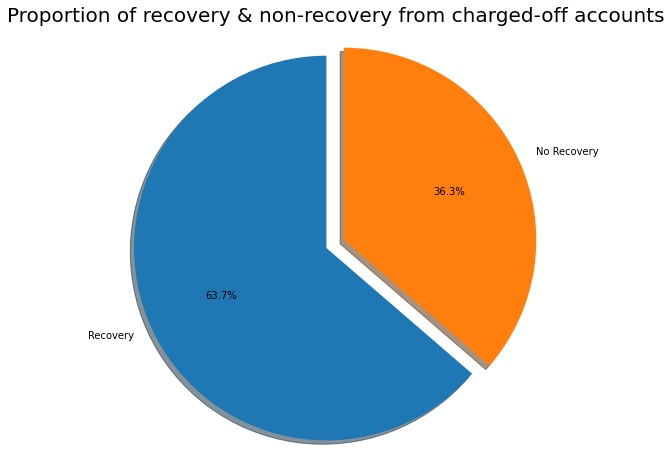

In [33]:
#Analyzing recovery status
sizes = [df.recovery_rate_encoded[df['recovery_rate_encoded']==1].count(), df.recovery_rate_encoded[df['recovery_rate_encoded']==0].count()]
plt.subplots(figsize=(10, 8))
plt.pie(sizes, explode=(0, 0.1), labels=['Recovery', 'No Recovery'], autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Proportion of recovery & non-recovery from charged-off accounts", size = 20)
plt.show()

- Of all the charged-off accounts`(12.83% of all the borrower accounts)`, the bank was able to recover only 63.7%.
- Unless remedial actions are taken, the bank will face serious losses on their end.

In [34]:
def barPerc(df,xVar,ax):
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable 
        ax: Axes object (for Seaborn Countplot/Bar plot or
                         pandas bar plot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.1%}',
                    ha="center",va="bottom")

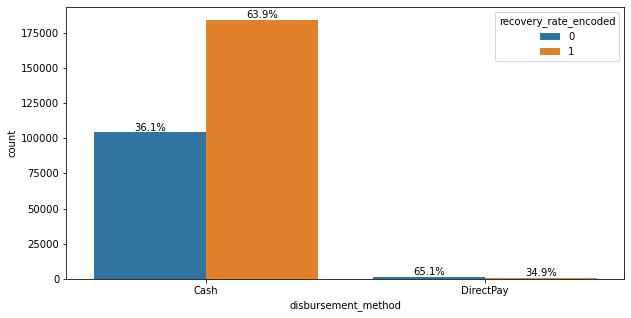

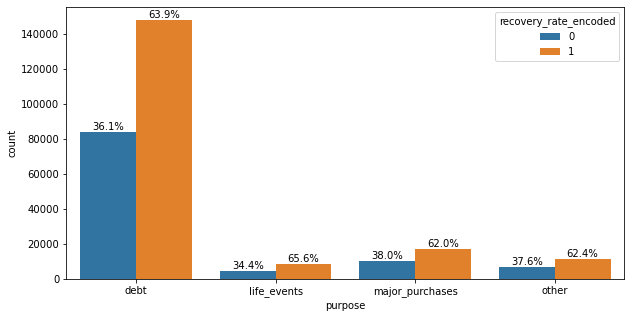

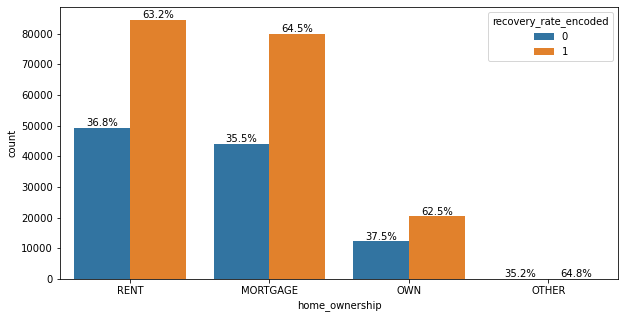

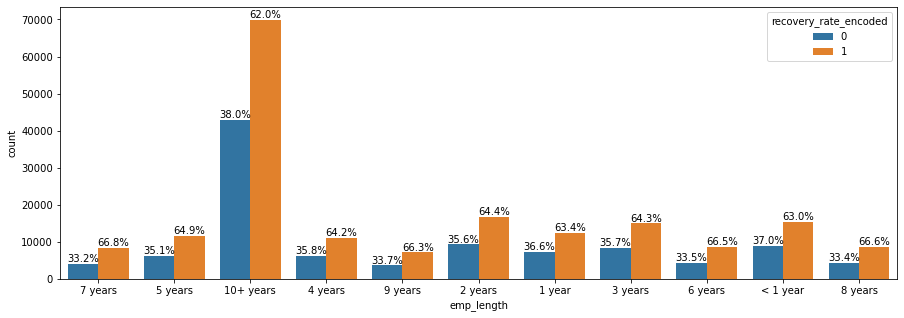

In [35]:
plt.figure(figsize = (10, 5))
ax=sns.countplot(x='disbursement_method', hue='recovery_rate_encoded', data=df)
(barPerc(df,'disbursement_method',ax))
plt.figure(figsize = (10, 5))
ax=sns.countplot(x='purpose', hue='recovery_rate_encoded', data=df)
(barPerc(df,'purpose',ax))
plt.figure(figsize = (10, 5))
ax=sns.countplot(x='home_ownership', hue='recovery_rate_encoded', data=df)
(barPerc(df,'home_ownership',ax))
plt.figure(figsize = (15, 5))
ax=sns.countplot(x='emp_length', hue='recovery_rate_encoded', data=df)
(barPerc(df,'emp_length',ax))

- Cash disbursement is the most resorted to method and hence, has the highest recovery and non-recovery rates.
- The loan defaulters who have mortgaged or rented homes contribute significantly in increasing the non-recovered amount of loans, which isn't surprising since the obligation of mortgage or rent payment inadvertently affects their ability to repay loans that in turn amounts to the bank not being able to recover either the principal or accrued interest from them.
- With regards to purpose of loan, 'debt' seems to stand high amongst defaulters as a crucial driver of non-recovery. This implies those who availed loans to pay off other liabilities and consumer debts has defaulted in payments, and thereby resulting in no recovery from the funded amount.
- High recovery and non-recovery rates among people who have been employed for over 10 years is observed.

#### Encoding Categorical Features

Create dummy variables of all the categorical features. This function removes one of the levels to avoid linear dependency using parameter 'drop_first'.

- "emp_length": Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

In [36]:
print(fullacc_clean['emp_length'].unique())

['10+ years' '3 years' '4 years' '6 years' '1 year' '7 years' '8 years'
 '5 years' '2 years' '9 years' '< 1 year']


- "verification_status": Indicates if income was verified by LC, not verified, or if the income source was verified

In [37]:
print(fullacc_clean['verification_status'].unique())

['Not Verified' 'Source Verified' 'Verified']


- "initial_list_status": The initial listing status of the loan

In [38]:
print(fullacc_clean['initial_list_status'].unique())

['w' 'f']


- "disbursement_method": The method by which the borrower receives their loan

In [39]:
print(fullacc_clean['disbursement_method'].unique())

['Cash' 'DirectPay']


In [40]:
def create_dummies(fullacc):
    
    categ_feats = ["emp_length", "home_ownership", "verification_status", "purpose", "initial_list_status", "region",
                 "disbursement_method"]
    for i in fullacc.columns:
        if i in categ_feats:
            # this gets dummies but deletes the first one to avoid linear dependency
            # if feature is needed dude to model importance, remove parameter = 'drop_first'
            fullacc = fullacc.join(pd.get_dummies(fullacc[i], prefix=i, drop_first=True))
        
    # drop original columns        
    fullacc = fullacc.drop(categ_feats, axis=1)
                                   
    return fullacc

data = create_dummies(fullacc_clean)

In [41]:
data.to_csv('fullacc_preprocessed_data_LGD_EAD.csv', index=False)

In [42]:
## end of notebook